# Importing packages

In [0]:
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
import IPython.display as display
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
# import tensorflow as tf
from PIL import Image
import numpy as np
# import keras
import PIL
import os

# Importing images

Mount Google Drive

In [3]:
## Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining functions

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
SPLIT = 0.2
trainPath = "/content/drive/My Drive/CMI/ImageData/Data/train/" 
testPath = "/content/drive/My Drive/CMI/ImageData/Data/test/"

In [0]:
def loadData(path, split = False):
    data_dir = path
    image_generator = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255, horizontal_flip = True, validation_split = SPLIT, 
                                                                   preprocessing_function = preprocess_input)
    if split:

        first_data_gen = image_generator.flow_from_directory(directory = data_dir,
                                                             batch_size = BATCH_SIZE,
                                                             shuffle = True,
                                                             target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                             subset='training')
        second_data_gen = image_generator.flow_from_directory(directory = data_dir,
                                                             batch_size = BATCH_SIZE,
                                                             shuffle = True,
                                                             target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                             subset='validation')
        return first_data_gen, second_data_gen
    data_gen = image_generator.flow_from_directory(directory = data_dir,
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   target_size = (IMG_HEIGHT, IMG_WIDTH))
    return data_gen

Loading data

In [6]:
trainData, valData = loadData(trainPath, split = True)
testData  = loadData(testPath)

Found 4320 images belonging to 15 classes.
Found 1080 images belonging to 15 classes.
Found 1800 images belonging to 15 classes.


Defining classes list

In [0]:
labels = list(trainData.class_indices.keys())
trainSteps = 4320/BATCH_SIZE
valSteps = 1020/BATCH_SIZE
testSteps = 1800/BATCH_SIZE

# Model ResNet 101

### Building the model

Function to build the model

In [0]:
def getModel(freeze = True):
  # Basic structure for feature extraction
  base_model = ResNet101(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
                       include_top = False,
                       weights = 'imagenet')
  
  # Freezeing/Unfreezing base model
  base_model.trainable = False
  if not freeze:
    base_model.trainable = True
    # fine_tune_at = 20
    # for layer in base_model.layers[:fine_tune_at]:
    #   layer.trainable =  False

  # Building classification layer
  poolingLayer = keras.layers.GlobalAveragePooling2D()
  # hiddenLayer1 = keras.layers.Dense(512, activation = "tanh")
  # hiddenLayer2 = keras.layers.Dense(128, activation = "relu")
  predictionLayer = keras.layers.Dense(15, activation = "softmax")

  # Adding classification layer to the base model
  model = keras.Sequential([base_model,
                            poolingLayer,
                            # hiddenLayer1,
                            # hiddenLayer2,
                            predictionLayer])
  
  return model

#### Frozen convolution base

Compiling model

In [0]:
# Defining number of epochs, learning rate
NUM_EPOCHS = 50
INIT_LR = 1e-2

In [0]:
modelFrozen = getModel()
opt = keras.optimizers.Adam(learning_rate = INIT_LR)
modelFrozen.compile(optimizer = opt,
                    loss = keras.losses.categorical_crossentropy,
                    metrics = ['accuracy'])

Training model

In [60]:
historyFrozen = modelFrozen.fit(trainData, validation_data = (valData), steps_per_epoch = trainSteps, validation_steps = valSteps, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/50
135/135 [==============================] - 118s 874ms/step - loss: 2.4968 - accuracy: 0.1903 - val_loss: 2.2440 - val_accuracy: 0.2274
Epoch 2/50
135/135 [==============================] - 115s 855ms/step - loss: 2.1860 - accuracy: 0.2694 - val_loss: 2.1480 - val_accuracy: 0.3135
Epoch 3/50
135/135 [==============================] - 118s 871ms/step - loss: 2.0959 - accuracy: 0.3109 - val_loss: 2.0479 - val_accuracy: 0.3447
Epoch 4/50
135/135 [==============================] - 115s 852ms/step - loss: 2.0849 - accuracy: 0.3231 - val_loss: 2.0092 - val_accuracy: 0.3169
Epoch 5/50
135/135 [==============================] - 119s 883ms/step - loss: 1.9435 - accuracy: 0.3648 - val_loss: 1.8268 - val_accuracy: 0.3848
Epoch 6/50
135/135 [==============================] - 113s 834ms/step - loss: 1.9425 - accuracy: 0.3574 - val_loss: 1.8389 - val_accuracy: 0.3740
Epoch 7/50
135/135 [==============================] - 115s 852ms/step - loss: 1.8856 - accuracy: 0.3873 - val_loss: 2.0093 -

In [61]:
# Train accuracy and report
print("Accuracy on train data::", historyFrozen.history["accuracy"][-1]*100)

Accuracy on train data:: 53.35648059844971


Testing

In [62]:
testAcc = modelFrozen.evaluate(testData, steps = testSteps)
print("Accuracy on test data::", testAcc[1]*100)

57/56 [==============================] - 38s 661ms/step - loss: 1.5864 - accuracy: 0.4661
Accuracy on test data:: 46.61111235618591


Plotting

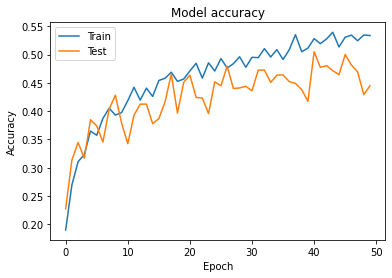

In [0]:
# Plot training & validation accuracy values
plt.plot(historyFrozen.history['accuracy'])
plt.plot(historyFrozen.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

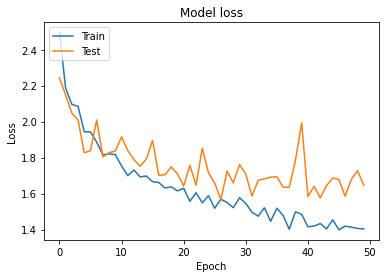

In [64]:
# Plot training & validation loss values
plt.plot(historyFrozen.history['loss'])
plt.plot(historyFrozen.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Unfrozen convolution base

In [0]:
# Defining number of epochs, learning rate
NUM_EPOCHS = 50
INIT_LR = 1e-2

In [0]:
modelUnFrozen = getModel(freeze = False)
opt = keras.optimizers.Adam(lr = INIT_LR)
modelUnFrozen.compile(optimizer = opt,
                      loss = keras.losses.categorical_crossentropy,
                      metrics = ['accuracy'])

Training model

In [16]:
historyUnFrozen = modelUnFrozen.fit(trainData, validation_data = (valData), steps_per_epoch = trainSteps, validation_steps = valSteps, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/50
135/135 [==============================] - 129s 952ms/step - loss: 3.3099 - accuracy: 0.1222 - val_loss: 64.2917 - val_accuracy: 0.0659
Epoch 2/50
135/135 [==============================] - 132s 976ms/step - loss: 2.2741 - accuracy: 0.2243 - val_loss: 3.3303 - val_accuracy: 0.1014
Epoch 3/50
135/135 [==============================] - 128s 949ms/step - loss: 2.0414 - accuracy: 0.2900 - val_loss: 2.5227 - val_accuracy: 0.1654
Epoch 4/50
135/135 [==============================] - 130s 961ms/step - loss: 1.8780 - accuracy: 0.3472 - val_loss: 3.0443 - val_accuracy: 0.1024
Epoch 5/50
135/135 [==============================] - 130s 961ms/step - loss: 1.7723 - accuracy: 0.3866 - val_loss: 3.9107 - val_accuracy: 0.2264
Epoch 6/50
135/135 [==============================] - 128s 945ms/step - loss: 1.5682 - accuracy: 0.4475 - val_loss: 3.0919 - val_accuracy: 0.2057
Epoch 7/50
135/135 [==============================] - 126s 933ms/step - loss: 1.4675 - accuracy: 0.4843 - val_loss: 2.7062 

In [18]:
# Train accuracy and report
print("Accuracy on train data::", historyUnFrozen.history["accuracy"][-1]*100)

Accuracy on train data:: 95.37037014961243


Testing

In [21]:
testAcc = modelUnFrozen.evaluate(testData, steps = testSteps)
print("Accuracy on test data::", testAcc[1]*100)

57/56 [==============================] - 442s 8s/step - loss: 1.9388 - accuracy: 0.6328
Accuracy on test data:: 63.277775049209595


Plotting

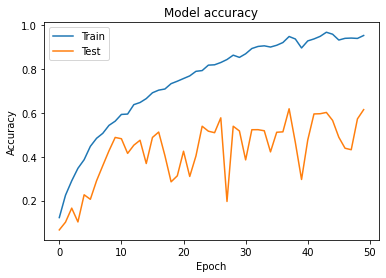

In [22]:
# Plot training & validation accuracy values
plt.plot(historyUnFrozen.history['accuracy'])
plt.plot(historyUnFrozen.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

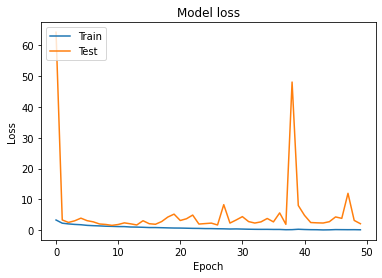

In [23]:
# Plot training & validation loss values
plt.plot(historyUnFrozen.history['loss'])
plt.plot(historyUnFrozen.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model ResNet V2

### Building the model

Building the model

In [0]:
def getModelV2(freeze = True):
  # Basic structure for feature extraction
  base_model = ResNet101V2(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
                           include_top = False,
                           weights = 'imagenet')
  
  # Freezeing/Unfreezing base model
  base_model.trainable = False
  if not freeze:
    base_model.trainable = True
    # fine_tune_at = 20
    # for layer in base_model.layers[:fine_tune_at]:
    #   layer.trainable =  False

  # Building classification layer
  poolingLayer = keras.layers.GlobalAveragePooling2D()
  # hiddenLayer1 = keras.layers.Dense(512, activation = "tanh")
  # hiddenLayer2 = keras.layers.Dense(128, activation = "relu")
  predictionLayer = keras.layers.Dense(15, activation = "softmax")

  # Adding classification layer to the base model
  model = keras.Sequential([base_model,
                            poolingLayer,
                            # hiddenLayer1,
                            # hiddenLayer2,
                            predictionLayer])
  
  return model

Compiling the model

In [0]:
# Defining number of epochs, learning rate
NUM_EPOCHS = 20
INIT_LR = 1e-2

In [0]:
modelV2 = getModelV2()
opt = keras.optimizers.Adam(learning_rate = INIT_LR)
modelV2.compile(optimizer = opt,
                loss = keras.losses.categorical_crossentropy,
                metrics = ['accuracy'])

Training model

In [37]:
historyV2 = modelV2.fit(trainData, validation_data = (valData), steps_per_epoch = trainSteps, validation_steps = valSteps, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/20
135/135 [==============================] - 119s 880ms/step - loss: 0.8072 - accuracy: 0.8366 - val_loss: 0.7012 - val_accuracy: 0.8711
Epoch 2/20
135/135 [==============================] - 119s 880ms/step - loss: 0.2931 - accuracy: 0.9359 - val_loss: 0.6148 - val_accuracy: 0.8947
Epoch 3/20
135/135 [==============================] - 120s 889ms/step - loss: 0.2579 - accuracy: 0.9472 - val_loss: 0.8057 - val_accuracy: 0.9045
Epoch 4/20
135/135 [==============================] - 118s 870ms/step - loss: 0.1683 - accuracy: 0.9611 - val_loss: 0.8788 - val_accuracy: 0.8967
Epoch 5/20
135/135 [==============================] - 118s 873ms/step - loss: 0.2105 - accuracy: 0.9542 - val_loss: 0.8812 - val_accuracy: 0.9016
Epoch 6/20
135/135 [==============================] - 118s 876ms/step - loss: 0.1786 - accuracy: 0.9641 - val_loss: 0.6896 - val_accuracy: 0.9281
Epoch 7/20
135/135 [==============================] - 117s 866ms/step - loss: 0.1191 - accuracy: 0.9755 - val_loss: 1.1783 -

In [38]:
# Train accuracy and report
print("Accuracy on train data::", historyV2.history["accuracy"][-1]*100)

Accuracy on train data:: 98.84259104728699


Testing

In [39]:
testAcc = modelV2.evaluate(testData, steps = testSteps)
print("Accuracy on test data::", testAcc[1]*100)

57/56 [==============================] - 38s 660ms/step - loss: 1.3806 - accuracy: 0.9072
Accuracy on test data:: 90.72222113609314


Plotting

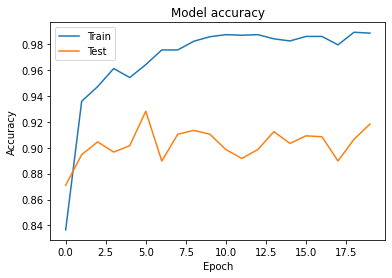

In [40]:
# Plot training & validation accuracy values
plt.plot(historyV2.history['accuracy'])
plt.plot(historyV2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

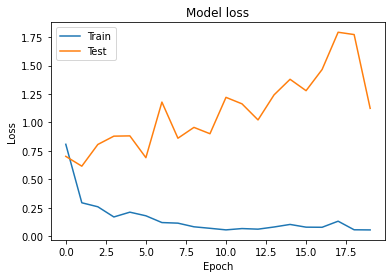

In [41]:
# Plot training & validation loss values
plt.plot(historyV2.history['loss'])
plt.plot(historyV2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()